<a href="https://colab.research.google.com/github/williamfazle/Machine-Learning/blob/main/titanic_dataset_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Step 1: Loading and Initial Inspection***

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

# Load the dataset built into seaborn for easy access
# (In a real scenario, you would load your train.csv)
df = sns.load_dataset('titanic')

# ---- Initial Inspection ----

# 1. View the first few rows to understand what the data looks like
print("--- First 5 Rows ---")
print(df.head())

# 2. View data types and non-null counts
# This is crucial for identifying missing data and categorical vs numerical columns.
print("\n--- DataFrame Info ---")
print(df.info())

# 3. Check exact count of missing values per column
print("\n--- Missing Value Count ---")
print(df.isnull().sum())

--- First 5 Rows ---
   survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
0         0       3    male  22.0      1      0   7.2500        S  Third   
1         1       1  female  38.0      1      0  71.2833        C  First   
2         1       3  female  26.0      0      0   7.9250        S  Third   
3         1       1  female  35.0      1      0  53.1000        S  First   
4         0       3    male  35.0      0      0   8.0500        S  Third   

     who  adult_male deck  embark_town alive  alone  
0    man        True  NaN  Southampton    no  False  
1  woman       False    C    Cherbourg   yes  False  
2  woman       False  NaN  Southampton   yes   True  
3  woman       False    C  Southampton   yes  False  
4    man        True  NaN  Southampton    no   True  

--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------

***Step 2: Handling Missing Values (Imputation)***

2a. The 'Cabin' Column (Too much missing data)

In [ ]:
# 'cabin' has too many missing values. Let's drop it.
# Note: The seaborn version also has redundant columns like 'deck', drop them too if present.
cols_to_drop = ['cabin', 'deck']
# Filter to only drop columns present in the dataframe
cols_to_drop = [col for col in cols_to_drop if col in df.columns]
df = df.drop(columns=cols_to_drop, axis=1)

print("Cabin column dropped.")

Cabin column dropped.


***2b. The 'Embarked' Column (Very little missing data)***

In [ ]:
# Find the most common embarkation point (mode)
most_common_embarked = df['embarked'].mode()[0]

print(f"Filling missing 'embarked' values with: {most_common_embarked}")

# Fill missing values
df['embarked'] = df['embarked'].fillna(most_common_embarked)
# If using the seaborn version, 'embark_town' is redundant, let's sync it or drop it later.
if 'embark_town' in df.columns:
     df['embark_town'] = df['embark_town'].fillna(df['embark_town'].mode()[0])

Filling missing 'embarked' values with: S


***2c. The 'Age' Column (Smarter Imputation)***

In [ ]:
# Group by Pclass and Sex, then transform 'age' by filling NaNs with the group's median
df['age'] = df.groupby(['pclass', 'sex'])['age'].transform(lambda x: x.fillna(x.median()))

# Verification check:
print("\nMissing values after imputation:")
print(df.isnull().sum())
# All counts should now be zero (except maybe 'who'/'adult_male' if using seaborn version, which we will drop later anyway).


Missing values after imputation:
survived       0
pclass         0
sex            0
age            0
sibsp          0
parch          0
fare           0
embarked       0
class          0
who            0
adult_male     0
embark_town    0
alive          0
alone          0
dtype: int64


***Step 3: Feature Engineering (Creating New Features)***

In [ ]:
# Create FamilySize: Siblings + Parents + The Passenger Themselves (+1)
df['FamilySize'] = df['sibsp'] + df['parch'] + 1

# Optional: Create a simpler feature "IsAlone" if FamilySize is 1
df['IsAlone'] = 0
df.loc[df['FamilySize'] == 1, 'IsAlone'] = 1

print("New features 'FamilySize' and 'IsAlone' created.")
print(df[['sibsp', 'parch', 'FamilySize', 'IsAlone']].head())

New features 'FamilySize' and 'IsAlone' created.
   sibsp  parch  FamilySize  IsAlone
0      1      0           2        0
1      1      0           2        0
2      0      0           1        1
3      1      0           2        0
4      0      0           1        1


***Step 4: Data Transformation and Encoding***

4a. Dropping Redundant/Useless Features

In [ ]:
# Columns that don't add predictive value for survival in their current form
# Note: 'passengerid' is usually in kaggle data, not seaborn load. Added for completeness.
useless_cols = ['passengerid', 'name', 'ticket']
redundant_seaborn_cols = ['class', 'who', 'adult_male', 'embark_town', 'alive', 'alone']

# Combine and filter for columns actually present
cols_to_drop_final = [col for col in (useless_cols + redundant_seaborn_cols) if col in df.columns]

df = df.drop(cols_to_drop_final, axis=1)

print("Redundant columns dropped.")
print(df.columns.tolist())
# Remaining columns should be roughly: ['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'FamilySize', 'IsAlone']

Redundant columns dropped.
['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'FamilySize', 'IsAlone']


***4b. Encoding Categorical Variables (One-Hot Encoding)***

In [ ]:
# Identify categorical columns for encoding
categorical_cols = ['sex', 'embarked']

# Apply One-Hot Encoding
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print("\nData after Encoding (Final State):")
print(df_encoded.head())
print("\nFinal Data Types:")
print(df_encoded.info())


Data after Encoding (Final State):
   survived  pclass   age  sibsp  parch     fare  FamilySize  IsAlone  \
0         0       3  22.0      1      0   7.2500           2        0   
1         1       1  38.0      1      0  71.2833           2        0   
2         1       3  26.0      0      0   7.9250           1        1   
3         1       1  35.0      1      0  53.1000           2        0   
4         0       3  35.0      0      0   8.0500           1        1   

   sex_male  embarked_Q  embarked_S  
0      True       False        True  
1     False       False       False  
2     False       False        True  
3     False       False        True  
4      True       False        True  

Final Data Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   survived    891 non-null    int64  
 1   pclass      891 non-null    int64  
 2   age 

# **Repeted Task**

In [1]:
# 0. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Optional: for reproducibility
RSEED = 42


**Step 1 — Load the data**

In [2]:
# Option A: seaborn built-in
import seaborn as sns
df = sns.load_dataset("titanic")

# Option B: local CSV
# df = pd.read_csv("/path/to/titanic.csv")


In [3]:
print(df.shape)
df.head()
df.info()
df.isnull().sum()


(891, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


,0
survived,0
pclass,0
sex,0
age,177
sibsp,0
parch,0
fare,0
embarked,2
class,0
who,0


**Step 2 — Quick EDA (get a feel)**

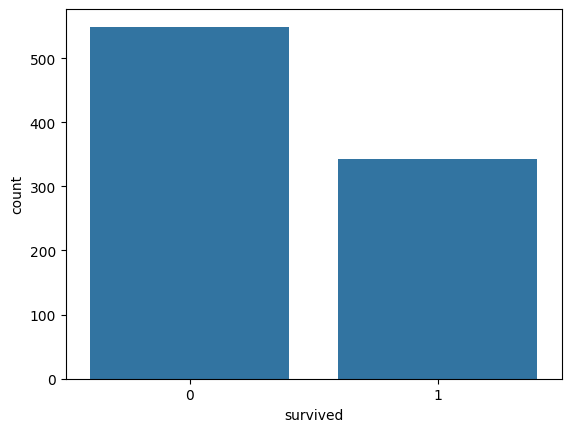

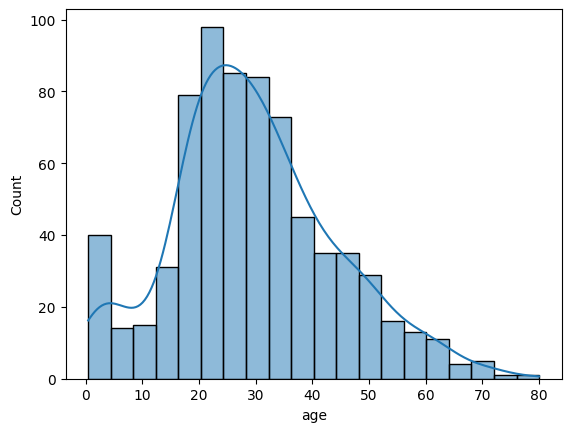

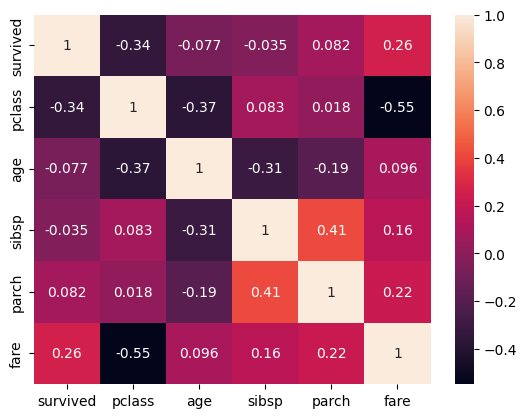

In [4]:
# basic stats
df.describe(include='all').T

# class balance
df['survived'].value_counts(normalize=True)

# some plots
sns.countplot(data=df, x='survived')
plt.show()

# numeric distributions
sns.histplot(df['age'], kde=True)
plt.show()

# correlation heatmap (numeric)
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True)
plt.show()


**Step 3 — Drop obviously useless columns**

Common candidates:

* deck (lots of missing)

* embark_town (redundant with embarked)

* alive (same as survived)

* who, adult_male (derived)

* class (redundant with pclass)
Decide based on your dataset.

In [5]:
drop_cols = ['deck','embark_town','alive','who','adult_male','class']
for c in drop_cols:
    if c in df.columns:
        df = df.drop(columns=c)


**Step 4 — Handle missing values (systematic)**

Strategy: numeric → median (robust), categorical → mode, others conditional.

In [6]:
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object','category','bool']).columns.tolist()
print("Num:", num_cols)
print("Cat:", cat_cols)


Num: ['survived', 'pclass', 'age', 'sibsp', 'parch', 'fare']
Cat: ['sex', 'embarked', 'alone']


Imputation

In [7]:
# Numeric imputer
num_imputer = SimpleImputer(strategy='median')

# Categorical imputer
cat_imputer = SimpleImputer(strategy='most_frequent')

# Apply
df[num_cols] = num_imputer.fit_transform(df[num_cols])
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])


**Step 5 — Create / engineer useful features**

In [8]:
# 1) Title from name
if 'name' in df.columns:
    df['title'] = df['name'].str.extract(r',\s*([^\.]+)\.')[0].str.strip()
    # collapse rare titles
    df['title'] = df['title'].replace(['Lady','Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona'],'Rare')
    df['title'] = df['title'].replace({'Mlle':'Miss','Ms':'Miss','Mme':'Mrs'})

# 2) Family size
if set(['sibsp','parch']).issubset(df.columns):
    df['family_size'] = df['sibsp'] + df['parch'] + 1
    df['is_alone'] = (df['family_size'] == 1).astype(int)

# 3) Fare per person
if 'fare' in df.columns and 'family_size' in df.columns:
    df['fare_per_person'] = df['fare'] / df['family_size']

# 4) Ticket frequency (how many have same ticket)
if 'ticket' in df.columns:
    ticket_counts = df['ticket'].value_counts()
    df['ticket_freq'] = df['ticket'].map(ticket_counts)

# 5) Drop or keep name/ticket id as needed (usually drop)
drop_after_engineer = ['name','ticket']
for c in drop_after_engineer:
    if c in df.columns:
        df = df.drop(columns=c)


**Step 6 — Handle outliers (numeric)**

In [9]:
def clip_iqr(series, k=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return series.clip(lower, upper)

for col in ['age','fare','fare_per_person']:  # check existence
    if col in df.columns:
        df[col] = clip_iqr(df[col])


**Step 7 — Encode categorical variables**

Two main options:

* ordinal/simple label encoding for ordered categories

* one-hot for nominal categories

In [10]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# choose feature lists
num_features = [c for c in df.select_dtypes(include=[np.number]).columns if c != 'survived']
cat_features = [c for c in df.select_dtypes(include=['object','category','bool']).columns]

# quick show
print("num_features:", num_features)
print("cat_features:", cat_features)


num_features: ['pclass', 'age', 'sibsp', 'parch', 'fare', 'family_size', 'is_alone', 'fare_per_person']
cat_features: ['sex', 'embarked', 'alone']


manual approach:

In [11]:
# Label encode small-cardinality categories (e.g., title)
from sklearn.preprocessing import LabelEncoder
if 'title' in df.columns:
    le = LabelEncoder()
    df['title_enc'] = le.fit_transform(df['title'])
    df = df.drop(columns=['title'])  # optionally drop original

# One-hot for embarked, sex, etc.
df = pd.get_dummies(df, columns=[c for c in ['sex','embarked'] if c in df.columns], drop_first=True)


**Step 8 — Scaling numeric features**

Use StandardScaler or RobustScaler (if outliers remain):

In [12]:
from sklearn.preprocessing import StandardScaler
num_to_scale = [c for c in num_features if c in df.columns]

scaler = StandardScaler()
df[[c + "_scaled" for c in num_to_scale]] = scaler.fit_transform(df[num_to_scale])

# Optionally drop raw numeric columns if you want only scaled versions
# df = df.drop(columns=num_to_scale)


**Step 9 — Remove duplicates & final checks**

In [13]:
# duplicates
print("duplicates before:", df.duplicated().sum())
df = df.drop_duplicates().reset_index(drop=True)
print("duplicates after:", df.duplicated().sum())

# final null check
print(df.isnull().sum())


duplicates before: 125
duplicates after: 0
survived                  0
pclass                    0
age                       0
sibsp                     0
parch                     0
fare                      0
alone                     0
family_size               0
is_alone                  0
fare_per_person           0
sex_male                  0
embarked_Q                0
embarked_S                0
pclass_scaled             0
age_scaled                0
sibsp_scaled              0
parch_scaled              0
fare_scaled               0
family_size_scaled        0
is_alone_scaled           0
fare_per_person_scaled    0
dtype: int64


**Step 10 — Train / Validation / Test split**

In [14]:
X = df.drop(columns=['survived'])
y = df['survived']

# simple train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RSEED, stratify=y
)

# optional: further split train -> train/val
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=RSEED, stratify=y_train)


# Save cleaned dataset

In [17]:
df.to_csv("titanic_cleaned.csv", index=False)
